In [5]:
# This is to be able to execute the ipynb files. This was performed through Google colab
!pip install cython
!pip install "vose<0.0.2" --no-build-isolation
!pip install sorobn
!pip install graphviz

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.8/129.8 kB 3.1 MB/s eta 0:00:00
  Preparing metadata (pyproject.toml) ... done
  Created wheel for vose: filename=vose-0.0.1-cp310-cp310-linux_x86_64.whl size=456051 sha256=00ae7334d5efacd9ba886476fba459973b005031317894571ea07cc8648ce711
  Stored in directory: /root/.cache/pip/wheels/7f/41/31/40f933f182decfa9300f85183d4043c5ed39fc941136e05ebc
Successfully built vose
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 53.7 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.2
    Uninstalling pandas-2.2.2:
      Successfully uninstalled pandas-2.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.10.1 requires pandas<2.2.3dev0,>=2.0, but you have pandas 1.5.3 which is incompatible.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 1.5.3 which 

# Learn to plot Bayesian Network

In [6]:
import graphviz

dot = graphviz.Digraph(comment='alarm')
dot.node('A', 'Burglary')
dot.node('B', 'Earthquake')
dot.node('C', 'Alarm')
dot.node('D', 'John calls')
dot.node('E', 'Mary calls')

dot.edges(['AC', 'BC', 'CD', 'CE'])

In [7]:
print(dot.source)

// alarm
digraph {
	A [label=Burglary]
	B [label=Earthquake]
	C [label=Alarm]
	D [label="John calls"]
	E [label="Mary calls"]
	A -> C
	B -> C
	C -> D
	C -> E
}



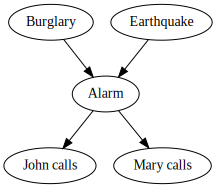

In [8]:
dot.render('round_table', directory='figures', format='svg', cleanup=True, view=True)
dot

**Task 1: convert the graph to Laplacian matrix (in degree), do this either on paper or just write out the matrix here**

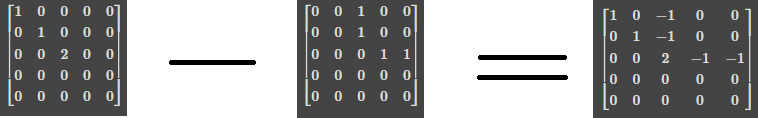

# Bayesian Network consutrction and inference

Read "alarm.png" file from the github link, use sorobn to construct the bayesian network

In [9]:
import sorobn as hh
import pandas as pd

bn = hh.BayesNet(
    ('Burglary', 'Alarm'),
    ('Earthquake', 'Alarm'),
    ('Alarm', 'John calls'),
    ('Alarm', 'Mary calls'),
    seed=42
  )

# P(Burglary)
bn.P['Burglary'] = pd.Series({False: .999, True: .001}) # P(Burglary=True) = 0.001, P(Burglary=False) = 0.999

# P(Earthquake)
bn.P['Earthquake'] = pd.Series({False: .998, True: .002}) # P(Earthquake=True) = 0.002, P(Earthquake=False) = 0.998

# P(Alarm | Burglary, Earthquake)
bn.P['Alarm'] = pd.Series({
              (True, True, True): .95, # P(Alarm=True | Burglary=True, Earthquake=True) = 0.95
              (True, True, False): .05, # P(Alarm=False | Burglary=True, Earthquake=True) = 0.05

              (True, False, True): .94, # P(Alarm=True | Burglary=True, Earthquake=False) = 0.94
              (True, False, False): .06, # P(Alarm=False | Burglary=True, Earthquake=False) = 0.06

              (False, True, True): .29, # P(Alarm=True | Burglary=False, Earthquake=True) = 0.29
              (False, True, False): .71, # P(Alarm=False | Burglary=False, Earthquake=True) = 0.71

              (False, False, True): .001, # P(Alarm=True | Burglary=False, Earthquake=False) = 0.001
              (False, False, False): .999 # P(Alarm=False | Burglary=False, Earthquake=False) = 0.999
          })




# P(John calls | Alarm)
bn.P['John calls'] = pd.Series({
     (True, True): .9, # P(John calls=True | Alarm=True) = 0.9
     (True, False): .1, # P(John calls=False | Alarm=True) = 0.1
     (False, True): .05,  # P(John calls=True | Alarm=False) = 0.05
     (False, False): .95  # P(John calls=False | Alarm=False) = 0.95
 })

# P(Mary calls | Alarm)
bn.P['Mary calls'] = pd.Series({
     (True, True): .7, # P(Mary calls=True | Alarm=True) = 0.7
     (True, False): .3,   # P(Mary calls=False | Alarm=True) = 0.3
     (False, True): .01, # P(Mary calls=True | Alarm=False) = 0.01
     (False, False): .99 # P(Mary calls=False | Alarm=False) = 0.99
 })


Make the network

In [10]:
bn.prepare()

# Bayesian network inference

What is the likelihood of there being a burglary if both John and Mary call?

In [11]:
bn.query('Burglary', event={'Mary calls': True, 'John calls': True})

,P(Burglary)
Burglary,
False,0.715828
True,0.284172


What are the chances that John and Mary call if an earthquake happens?

In [12]:
bn.query('John calls', 'Mary calls', event={'Earthquake': True})

John calls  Mary calls
False       False         0.675854
            True          0.027085
True        False         0.113591
            True          0.183470
Name: P(John calls, Mary calls), dtype: float64

Practice.png

In [14]:
bn = hh.BayesNet(
    ("A", "B"),
    ("B", "F"),
    ("C", "D"),
    ("D", "F"),
    seed=42,
) # Correct connections between nodes, just need to add probabilities like above

# Essentially follow the same format as above, just adjust the values to fit the practice.png

# P(Burglary)
bn.P['Burglary'] = pd.Series({False: .999, True: .001}) # P(Burglary=True) = 0.001, P(Burglary=False) = 0.999

# P(Earthquake)
bn.P['Earthquake'] = pd.Series({False: .998, True: .002}) # P(Earthquake=True) = 0.002, P(Earthquake=False) = 0.998

# P(Alarm | Burglary, Earthquake)
bn.P['Alarm'] = pd.Series({
              (True, True, True): .95, # P(Alarm=True | Burglary=True, Earthquake=True) = 0.95
              (True, True, False): .05, # P(Alarm=False | Burglary=True, Earthquake=True) = 0.05

              (True, False, True): .94, # P(Alarm=True | Burglary=True, Earthquake=False) = 0.94
              (True, False, False): .06, # P(Alarm=False | Burglary=True, Earthquake=False) = 0.06

              (False, True, True): .29, # P(Alarm=True | Burglary=False, Earthquake=True) = 0.29
              (False, True, False): .71, # P(Alarm=False | Burglary=False, Earthquake=True) = 0.71

              (False, False, True): .001, # P(Alarm=True | Burglary=False, Earthquake=False) = 0.001
              (False, False, False): .999 # P(Alarm=False | Burglary=False, Earthquake=False) = 0.999
          })




# P(John calls | Alarm)
bn.P['John calls'] = pd.Series({
     (True, True): .9, # P(John calls=True | Alarm=True) = 0.9
     (True, False): .1, # P(John calls=False | Alarm=True) = 0.1
     (False, True): .05,  # P(John calls=True | Alarm=False) = 0.05
     (False, False): .95  # P(John calls=False | Alarm=False) = 0.95
 })

# P(Mary calls | Alarm)
bn.P['Mary calls'] = pd.Series({
     (True, True): .7, # P(Mary calls=True | Alarm=True) = 0.7
     (True, False): .3,   # P(Mary calls=False | Alarm=True) = 0.3
     (False, True): .01, # P(Mary calls=True | Alarm=False) = 0.01
     (False, False): .99 # P(Mary calls=False | Alarm=False) = 0.99
 })

bn.P['A'] = pd.Series({False: .9, True: .1})

bn.P['B'] = pd.Series({
     (True, True): .4, # P(B = True | A=True) = 0.4
     (True, False): .6, # P(B = False | A=True) = 0.6
     (False, True): .9,  # P(B = True | A=False) = 0.9
     (False, False): .1  # P(B = False | A=False) = 0.1
 })

bn.P['C'] = pd.Series({False: .9, True: .1})

bn.P['D'] = pd.Series({
     (True, True): .3, # P(D = True | C=True) = 0.3
     (True, False): .7, # P(D = False | C=True) = 0.7
     (False, True): .6,  # P(D = True | C=False) = 0.6
     (False, False): .4  # P(D = False | C=False) = 0.4
 })

bn.P['F'] = pd.Series({
              (True, True, True): .7, # P(F=True | B=True, D=True) = 0.7
              (True, True, False): .3, # P(F=False | B=True, D=True) = 0.3

              (True, False, True): .4, # P(F=True | B=True, D=False) = 0.4
              (True, False, False): .6, # P(F=False | B=True, D=False) = 0.6

              (False, True, True): .2, # P(F=True | B=False, D=True) = 0.2
              (False, True, False): .8, # P(F=False | B=False, D=True) = 0.8

              (False, False, True): 0, # P(F=True | B=False, D=False) = 0
              (False, False, False): 1, # P(F=False | B=False, D=False) = 1
          })


bn.prepare()


**Task 2:** What is the likelihood of F is true if A&D is true, B&C is False?

In [24]:
bn.query("F", event={"A": True, "B": True, "C": False, "D": True})

,P(F)
F,
False,0.3
True,0.7


**Task 3:** What is the likelihood of F is False if A&B is False, C&D is True?

In [25]:
bn.query("F", event={"A": False, "B": False, "C": True, "D": True})

,P(F)
F,
False,0.8
True,0.2
